In [1]:
#import pyarrow.feather as feather
import pandas as pd
import numpy as np
import os
import seaborn as sns
sns.set(color_codes=True)
from numpy.random import seed
#from scipy.io import netcdf
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

from math import sqrt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from keras.models import Model
from keras import regularizers

In [4]:
# it is better for visualisation if the columns date type (not int or str)
# when save df to csv, if the column names are date, they are saved as str
def convert_col_to_date(columns):
    
    # convert the columns type
    #columns = df.columns
    new_columns = []
    for col in columns:
        try:
            new_columns.append(pd.to_datetime(col).date())
        except: new_columns.append(col)
    return new_columns

In [52]:
# import freq df
k=3 #sample number
freq_level =  pd.read_csv(f"dataset/modeling/sample{k}/freq_sample.csv").set_index("proj_id")
print(freq_level.shape)
print(" ")
print("details: ")
print(f"daily_freq: {freq_level[freq_level['daily']].shape}")
print(f"mid_weekly_freq: {freq_level[freq_level['mid_weekly']].shape}")
print(f"weekly_freq: {freq_level[freq_level['weekly']].shape}")
print(f"fortnight_freq: {freq_level[freq_level['fortnight']].shape}")
print(f"low_freq_freq: {freq_level[freq_level['low_freq']].shape}")

freq_level.sort_values(["freq", "length"]).head()

(25, 7)
 
details: 
daily_freq: (5, 7)
mid_weekly_freq: (5, 7)
weekly_freq: (5, 7)
fortnight_freq: (5, 7)
low_freq_freq: (5, 7)


,daily,mid_weekly,weekly,fortnight,low_freq,length,freq
proj_id,,,,,,,
NW_110200469,True,False,False,False,False,1356,1
MV_20480008,True,False,False,False,False,2058,1
BB_31519239,True,False,False,False,False,3770,1
NI_200000700,True,False,False,False,False,4659,1
BY_11163,True,False,False,False,False,5962,1


In [6]:
# import t s and convert into date type
grouped_t_s = pd.read_csv(f"dataset/modeling/sample{k}/sample_t_s.csv").set_index("proj_id")
grouped_t_s.columns = convert_col_to_date(grouped_t_s.columns)
print(grouped_t_s.shape)
grouped_t_s.head()

(25, 6546)


,length,freq,1995-01-01,1995-01-02,1995-01-03,1995-01-04,1995-01-05,1995-01-06,1995-01-07,1995-01-08,...,2012-11-21,2012-11-22,2012-11-23,2012-11-24,2012-11-25,2012-11-26,2012-11-27,2012-11-28,2012-11-29,2012-11-30
proj_id,,,,,,,,,,,,,,,,,,,,,
NW_110200469,1356,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,78.31000,78.30000,78.30000,78.32000,78.32000,78.3400,78.33000,78.33000,78.31000,78.30000
MV_20480008,2058,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.02000,2.01000,2.01000,2.01000,2.03000,2.0200,2.02000,2.02000,2.03000,2.01000
BB_31519239,3770,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.21000,2.19000,2.19000,2.19000,2.20000,2.1900,NaN,NaN,NaN,NaN
NI_200000700,4659,1,44.66,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,43.73000,43.73000,43.73000,43.73000,43.73000,43.7300,43.73000,43.73000,43.73000,43.73000
BY_11163,5962,1,NaN,373.08399,NaN,NaN,NaN,NaN,NaN,NaN,...,370.43615,370.40831,370.41854,370.42508,370.44492,370.4701,370.50575,370.54035,370.57969,370.52173


In [7]:
# import ave_temp 
ave_temp = pd.read_csv(f"dataset/modeling/sample{k}/sample_temp.csv").set_index("proj_id")
ave_temp.columns = convert_col_to_date(ave_temp.columns)
print(ave_temp.shape)
ave_temp.head()


(25, 6546)


,length,freq,1995-01-01,1995-01-02,1995-01-03,1995-01-04,1995-01-05,1995-01-06,1995-01-07,1995-01-08,...,2012-11-21,2012-11-22,2012-11-23,2012-11-24,2012-11-25,2012-11-26,2012-11-27,2012-11-28,2012-11-29,2012-11-30
proj_id,,,,,,,,,,,,,,,,,,,,,
NW_110200469,1356,1,9.0,9.0,-10.0,-58.0,-66.0,-57.0,-76.0,-36.0,...,53.0,80.0,60.0,72.0,104.0,64.0,73.0,38.0,32.0,4.0
MV_20480008,2058,1,17.0,2.0,-13.0,-41.0,-57.0,-67.0,-65.0,-55.0,...,50.0,61.0,40.0,47.0,60.0,68.0,64.0,47.0,47.0,22.0
BB_31519239,3770,1,24.0,-1.0,-12.0,-61.0,-55.0,-77.0,-54.0,-51.0,...,42.0,58.0,29.0,57.0,68.0,61.0,69.0,52.0,44.0,26.0
NI_200000700,4659,1,11.0,7.0,-20.0,-74.0,-77.0,-70.0,-75.0,-37.0,...,45.0,77.0,56.0,53.0,96.0,70.0,68.0,35.0,32.0,12.0
BY_11163,5962,1,2.0,-24.0,-41.0,-98.0,-124.0,-105.0,-100.0,-72.0,...,22.0,35.0,44.0,35.0,64.0,68.0,62.0,50.0,6.0,-10.0


In [8]:
# import the cum_prec 
cum_prec=pd.read_csv(f"dataset/modeling/sample{k}/sample_prec.csv").set_index("proj_id")
cum_prec.columns = convert_col_to_date(cum_prec.columns)
print(cum_prec.shape)
cum_prec.head()

(25, 6546)


,length,freq,1995-01-01,1995-01-02,1995-01-03,1995-01-04,1995-01-05,1995-01-06,1995-01-07,1995-01-08,...,2012-11-21,2012-11-22,2012-11-23,2012-11-24,2012-11-25,2012-11-26,2012-11-27,2012-11-28,2012-11-29,2012-11-30
proj_id,,,,,,,,,,,,,,,,,,,,,
NW_110200469,1356,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,26.0,19.0,1.0,28.0,2.0,0.0,1.0,2.0
MV_20480008,2058,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,8.0,5.0,2.0,28.0,1.0,9.0,53.0,0.0
BB_31519239,3770,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,22.0,13.0,4.0,6.0,12.0,68.0,164.0,3.0
NI_200000700,4659,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,26.0,31.0,1.0,34.0,0.0,0.0,0.0,8.0
BY_11163,5962,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,2.0,176.0,155.0,2.0


In [9]:
###########################################################################################################

# func

In [10]:
# create df for a t s (one row in grouped_t_s df)
def create_one_ts_df(row):
    bgr = row.name
    idx = row.dropna().index[2:]
    ts = row[idx]
    temp = ave_temp[idx].loc[bgr]
    prec = cum_prec[idx].loc[bgr]
    df = pd.DataFrame({"ts":ts,"temp": temp,"prec":prec, })
    return df


# pick up one ts with its corresponding temp and prec, and plot them all

ts length:2762.0, freq: 4.0
(2731, 3)


Text(0.5, 1.0, 'prec')

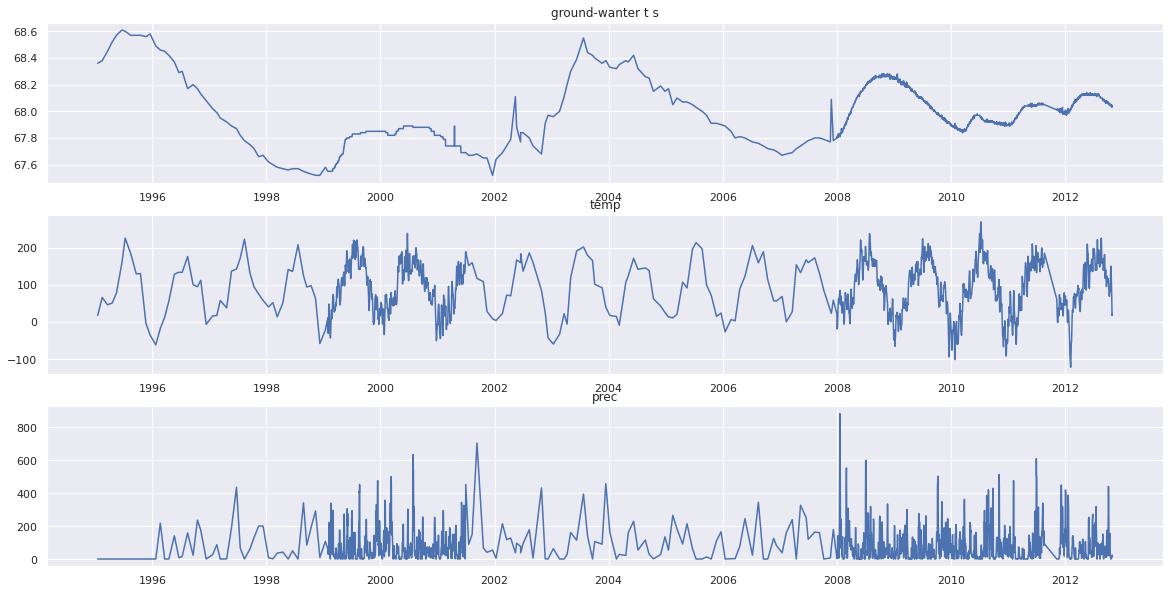

In [53]:
# apply the func
ts1 = grouped_t_s.iloc[9]
print(f"ts length:{ts1[0]}, freq: {ts1[1]}")
df = create_one_ts_df(ts1)
print(df.shape)
# plot a t s with its predictors
fig, axs = plt.subplots(3,1, figsize=(20,10))
#fig.suptitle('Vertically stacked subplots')
a,b = 0,2700
axs[0].plot(df["ts"][a:b])
axs[0].set_title('ground-wanter t s')
axs[1].plot(df["temp"][a:b])
axs[1].set_title('temp')
axs[2].plot(df["prec"][a:b])
axs[2].set_title('prec')

# Autoencoder LSTM model: 

In [25]:

# split df into train 80% and test 20%, 
n_train = int(len(df)*0.8)
train = df[:n_train]
test = df[n_train:]

# normalize the data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(train)
X_test = scaler.transform(test)

# reshape inputs for LSTM [samples, timesteps, features]
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
print("Training data shape:", X_train.shape)
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
print("Test data shape:", X_test.shape)



Training data shape: (2184, 1, 3)
Test data shape: (547, 1, 3)


In [26]:
# define the autoencoder network model
def autoencoder_model(X):
    # define the input vector
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    # compress the input data (encoder)
    L1 = LSTM(16, activation='relu', return_sequences=True,kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = LSTM(4, activation='relu', return_sequences=False)(L1)
    # distribute the compressed representational vector across the time steps of the decoder
    L3 = RepeatVector(X.shape[1])(L2)
    # decompress the  data (decoder)
    L4 = LSTM(4, activation='relu', return_sequences=True)(L3)
    L5 = LSTM(16, activation='relu', return_sequences=True)(L4)
    # reconstructed input data
    output = TimeDistributed(Dense(X.shape[2]))(L5)    
    model = Model(inputs=inputs, outputs=output)
    return model

# create the autoencoder model
model = autoencoder_model(X_train)
model.compile(optimizer='adam', loss='mae')
model.summary()


In [28]:
# fit the model to the data
nb_epochs = 100
batch_size = 10
history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size,validation_split=0.05).history


Epoch 1/100
208/208 [==============================] - 6s 8ms/step - loss: 0.2845 - val_loss: 0.1088
Epoch 2/100
208/208 [==============================] - 1s 5ms/step - loss: 0.0945 - val_loss: 0.0888
Epoch 3/100
208/208 [==============================] - 2s 8ms/step - loss: 0.0854 - val_loss: 0.0904
Epoch 4/100
208/208 [==============================] - 2s 9ms/step - loss: 0.0823 - val_loss: 0.0784
Epoch 5/100
208/208 [==============================] - 2s 10ms/step - loss: 0.0799 - val_loss: 0.0751
Epoch 6/100
208/208 [==============================] - 2s 10ms/step - loss: 0.0772 - val_loss: 0.0675
Epoch 7/100
208/208 [==============================] - 2s 9ms/step - loss: 0.0736 - val_loss: 0.0645
Epoch 8/100
208/208 [==============================] - 2s 9ms/step - loss: 0.0716 - val_loss: 0.0597
Epoch 9/100
208/208 [==============================] - 2s 8ms/step - loss: 0.0712 - val_loss: 0.0559
Epoch 10/100
208/208 [==============================] - 2s 8ms/step - loss: 0.0696 - val_

208/208 [==============================] - 1s 4ms/step - loss: 0.0674 - val_loss: 0.0430
Epoch 82/100
208/208 [==============================] - 1s 4ms/step - loss: 0.0687 - val_loss: 0.0403
Epoch 83/100
208/208 [==============================] - 1s 5ms/step - loss: 0.0687 - val_loss: 0.0412
Epoch 84/100
208/208 [==============================] - 1s 6ms/step - loss: 0.0681 - val_loss: 0.0397
Epoch 85/100
208/208 [==============================] - 1s 4ms/step - loss: 0.0683 - val_loss: 0.0404
Epoch 86/100
208/208 [==============================] - 1s 4ms/step - loss: 0.0678 - val_loss: 0.0392
Epoch 87/100
208/208 [==============================] - 1s 4ms/step - loss: 0.0685 - val_loss: 0.0394
Epoch 88/100
208/208 [==============================] - 1s 4ms/step - loss: 0.0660 - val_loss: 0.0395
Epoch 89/100
208/208 [==============================] - 1s 4ms/step - loss: 0.0695 - val_loss: 0.0400
Epoch 90/100
208/208 [==============================] - 1s 4ms/step - loss: 0.0680 - val_loss: 

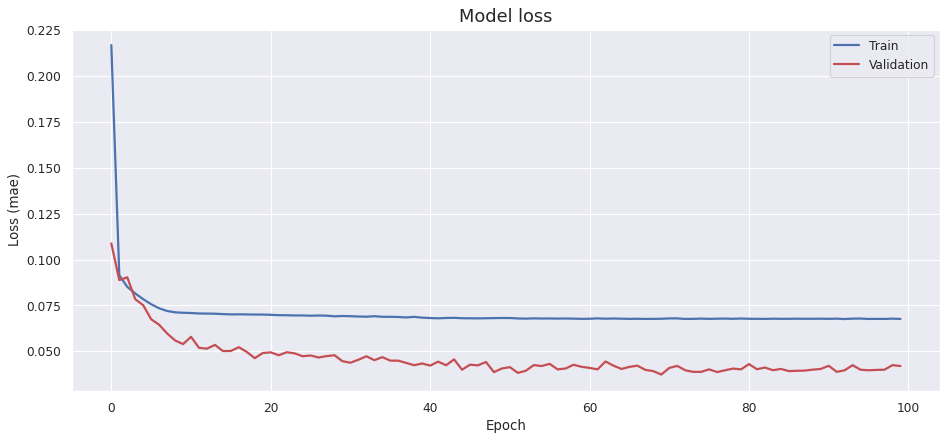

In [29]:
# plot the training losses
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

(0.0, 0.5)

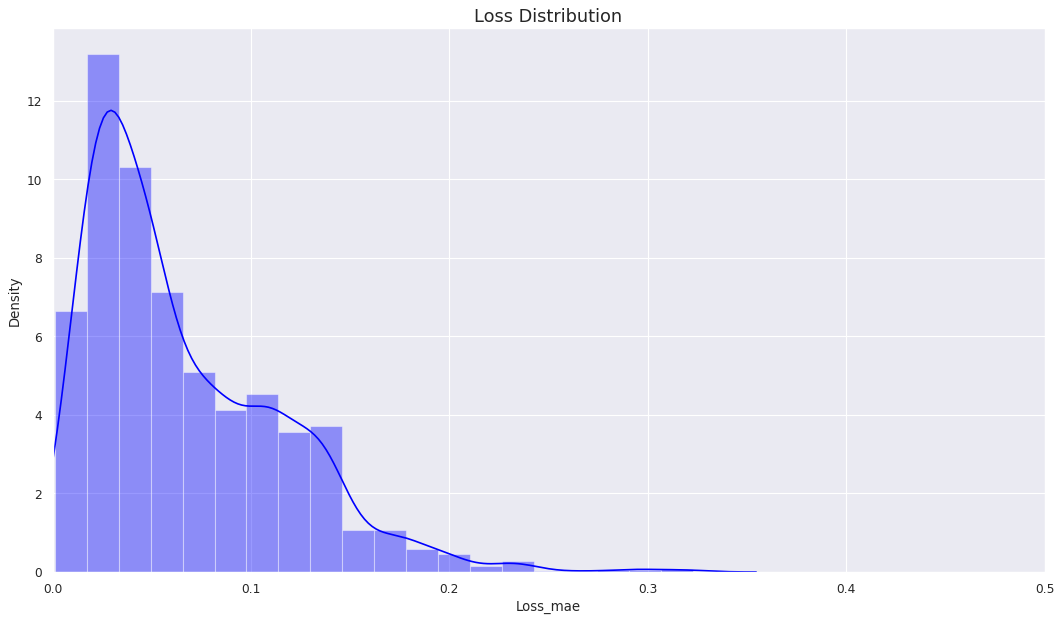

In [30]:
# plot the loss distribution of the training set
# reconstruct the training dataset (predicting)
X_pred = model.predict(X_train)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=train.columns)
X_pred.index = train.index

# compute the loss (error between the predcted training and the original training)
scored = pd.DataFrame(index=train.index)
Xtrain = X_train.reshape(X_train.shape[0], X_train.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtrain), axis = 1)
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.distplot(scored['Loss_mae'], bins = 20, kde= True, color = 'blue');
plt.xlim([0.0,.5])

In [31]:
# compute a threshold -> four std from the mean of the loss
thre = np.mean(scored,axis=0)[0]+4*np.std(scored,axis=0)[0]
thre

0.26342238731080814

## the outliers are the points that have loss higher than the threshold
## 

In [32]:
# calculate the loss on the test set
X_pred = model.predict(X_test)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=test.columns)
X_pred.index = test.index

scored = pd.DataFrame(index=test.index)
Xtest = X_test.reshape(X_test.shape[0], X_test.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtest), axis = 1)
scored['Threshold'] = thre# 0.175
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
scored.head()

,Loss_mae,Threshold,Anomaly
2011-03-17,0.054743,0.263422,False
2011-03-18,0.062472,0.263422,False
2011-03-19,0.062788,0.263422,False
2011-03-20,0.062695,0.263422,False
2011-03-21,0.067492,0.263422,False


In [33]:
# calculate the same metrics for the training set 
# and merge all data in a single dataframe for plotting
X_pred_train = model.predict(X_train)
X_pred_train = X_pred_train.reshape(X_pred_train.shape[0], X_pred_train.shape[2])
X_pred_train = pd.DataFrame(X_pred_train, columns=train.columns)
X_pred_train.index = train.index

scored_train = pd.DataFrame(index=train.index)
scored_train['Loss_mae'] = np.mean(np.abs(X_pred_train-Xtrain), axis = 1)
scored_train['Threshold'] = thre
scored_train['Anomaly'] = scored_train['Loss_mae'] > scored_train['Threshold']
scored = pd.concat([scored_train, scored])

In [58]:
scored[scored["Anomaly"]==True]

,Loss_mae,Threshold,Anomaly
2001-09-10,0.305881,0.263422,True
2003-07-24,0.322069,0.263422,True
2003-12-14,0.307421,0.263422,True
2008-01-21,0.322913,0.263422,True
2008-01-22,0.268117,0.263422,True
2008-07-04,0.286874,0.263422,True
2008-07-05,0.290339,0.263422,True
2008-07-06,0.294792,0.263422,True


In [57]:
anomaly = scored[scored["Anomaly"]==True].index
anomaly

Index([2001-09-10, 2003-07-24, 2003-12-14, 2008-01-21, 2008-01-22, 2008-07-04,
       2008-07-05, 2008-07-06],
      dtype='object')

<AxesSubplot:>

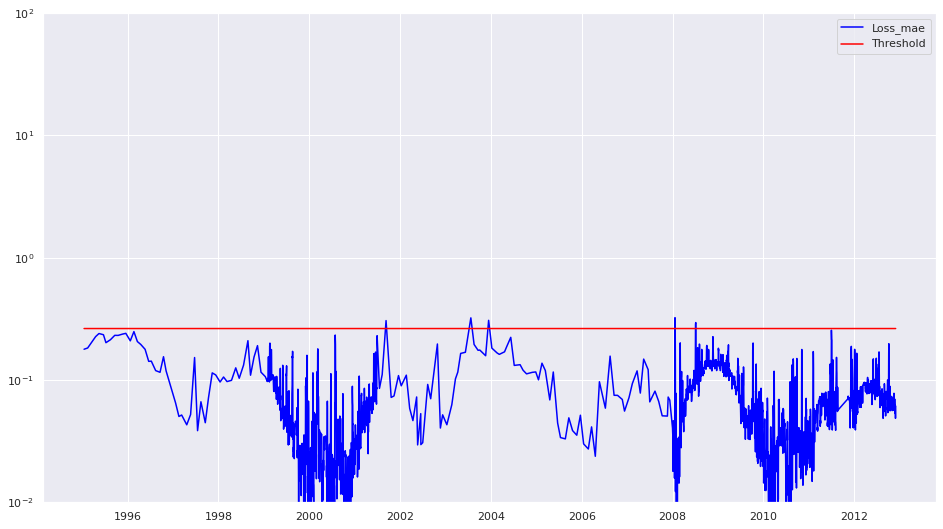

In [59]:
# plot bearing failure time plot
scored.plot(logy=True,  figsize=(16,9), ylim=[1e-2,1e2], color=['blue','red'])


Text(0.5, 1.0, 'prec')

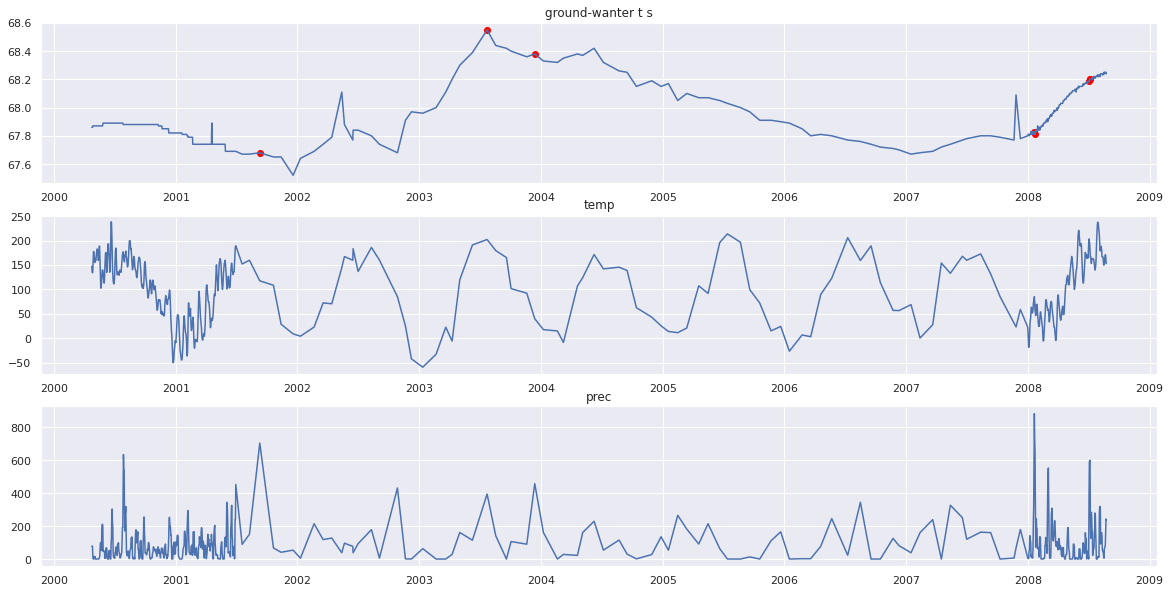

In [65]:
# plot a t s with its predictors
fig, axs = plt.subplots(3,1, figsize=(20,10))
#fig.suptitle('Vertically stacked subplots')
a,b = 500,1250
axs[0].plot(df["ts"][a:b])
axs[0].scatter(anomaly[:], df["ts"][anomaly][:], color="red")
axs[0].set_title('ground-wanter t s')
axs[1].plot(df["temp"][a:b])
axs[1].set_title('temp')
axs[2].plot(df["prec"][a:b])
axs[2].set_title('prec')